In [808]:
from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing the Models

Use a wildcard and specify the path of the ensemble members for the design value

In [809]:
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/daily/processed/hdd/*ann_ta.nc'
#PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jan1.0p/*.nc'

Read in ensembles and put in a xarray dataset

In [810]:
ds = read_data(PATH)
dv_field = ds['dv'].values.copy()

tas


load the land mask

In [811]:
mask = load_land_mask('./mask.nc')

Check for any NaN values, and if there are any in the ensemble, disqualify that grid cell from the rest of the analysis. Combine the land mask and the nan mask using `logical disjoint`.


In [812]:
mask_master = mask_land_and_nan(dv_field, mask)

Flatten the master mask into ensemble space to reference the grid cell number that the mask corresponds to. 

In [816]:
idx = mask_land_and_nan_ens_index(mask_master)

Calculate the areas of each grid cell.

In [817]:
area = frac_grid_area(ds['dv'])
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape

(1, 20150)

Flatten the ensemble data cube design values.

In [838]:
ens = ens_flat(ds['dv'].values)

Calculate the mean of each grid cell along the ensemble members.

In [821]:
mean = ens.mean(axis=0).reshape(1, -1)

Weight each design value in the ensemble by its corresponding grid cell area, then subtract the mean of that grid cell across the ensemble. This corresponds to 
$$X' = \left(I_n - \frac{1}{n}1_n\right)X$$
and
$$X'_w = X' W$$
in Chao's methods.

In [822]:
corr_ens = (ens - mean)*area_relevent_grid_cells                                   

The next step is to calculate the first $N$ eof's that explain up to 95% of the variance. Then take only the relavent grid cells by the master mask's ensemble representation, with indices in `idx`

In [823]:
ens_eof = ens_to_eof(corr_ens).components_[:, idx]
print("EOF Shape: ", ens_eof.shape)

EOF Shape:  (27, 9022)


With the fitted EOF pattern, we can take a look at how the EOFs reduce the dimensionality of the ensemble space, by looking at the `explained variance` of each principal component.

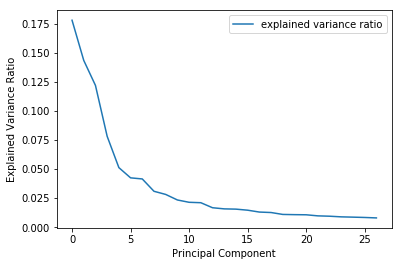

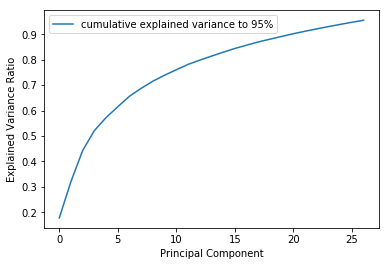

In [824]:
sns.lineplot(range(ens_eof.shape[0]), 
             ens_to_eof(corr_ens).explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
sns.lineplot(range(ens_eof.shape[0]), 
             np.cumsum(ens_to_eof(corr_ens).explained_variance_ratio_),
             label='cumulative explained variance to 95%')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

Extend the rotated latitude and longitude into the ensemble space, assigning a lat and lon to each grid cell in the ensemble array. Also correct the rotated pole configuration into a non-rotated reference frame.

In [926]:
rlon = ds['rlon'].values.copy()
rlat = ds['rlat'].values.copy()

rlon_ens = np.tile(rlon, rlat.shape[0])
rlat_ens = np.repeat(rlat, rlon.shape[0])

from pyproj import CRS
import pyproj
from pyproj import Transformer
from pyproj.enums import WktVersion

rpole = CRS.from_proj4("+proj=ob_tran +o_proj=longlat +R=6371000 +lon_0=-97 +o_lat_p=42.5 +a=1 +to_meter=0.0174532925199 +no_defs")
rpole = CRS(rpole)
crs_4326 = CRS(CRS.from_epsg(4326))

transformer = pyproj.transform(rpole, 4326, 50, -80)
"""
lat_lon_ens = correct_extend_rlat_and_rlon_to_ens(rlat_ens, rlon_ens)[idx, :]
lat_ens, lon_ens = zip(*lat_lon_ens)
sns.scatterplot(lon_ens, lat_ens)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('CanRCM4_projection')"""

ProjError: Input is not a transformation.

We are now done with preprocessing the models. 

### Observations

Read in the MSC query observations, and zip together the latitude and longitudes of the stations where the observations were found into a list of tuples representing lat,lon coordinates.

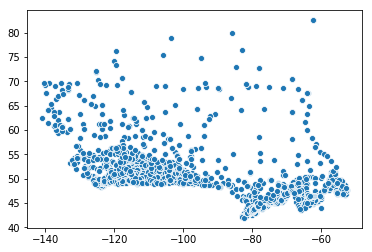

In [880]:
df = pd.read_csv('jan_1st_percentile_1991_2016', index_col=None)
lat_lon_obs = list(zip(df['lat'], df['lon']))
lat_obs, lon_obs = zip(*lat_lon_obs)
sns.scatterplot(lon_obs, lat_obs)

Using the euclidean distance, find the _**index location**_ of the grid in the ensemble space that is closest to the observation. Add it to the dataframe. 

Note that this method only tells us which grid cell in the ensemble space is closest to the observation lat, lon. It does not tell us what the actual lat,lon value of that grid cell is.

In [827]:
df['nearest_grid'] = euclidean_dist_index(lat_lon_obs, lat_lon_ens)

If more than one station occupy a CanRCM4 grid cell, take the mean of all of those station's design value.

In [828]:
ndf = df['quantile'].groupby(df['nearest_grid']).mean()

# create an array containing the indices in ensemble space
# of the corresponding observed design values
match_ens_obs_idx = np.asarray(ndf.index)

Weight the observations by area, just like they were weighted in the models. 

$$y_g' = y_g W$$

Only bother with the indices that are matched to the ensemble space.


In [829]:
match_obs_ens = np.array(ndf)*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (27, 583) 
Matched Obs shape:  (583,)


Now regress the matched ensemble array EOFs with the observations, and create a model via least squares regression. Corresponding to the EOFs where $\beta$ and $\epsilon$ are the best fit parameter vectors.
$$y_{g, \perp} = V_{1:k, \perp}\beta+\epsilon$$

In [830]:
model = regress_eof(match_model_ens.T, match_obs_ens[0, :])

Model score: 0.6606232764464584


Now that the model is created, we can use it to reconstruct design values for the rest of the grid cells in the ensemble. 

In [831]:
predictions = predict_dv(model, ens_eof.T)

In [832]:
latlist, lonlist = zip(*list(lat_lon_ens))

In [833]:
observations = .10*match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx] 
reconstructed_observations = .10*predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx]
observations.shape, reconstructed_observations.shape

((1, 583), (1, 583))

0.6440933662684548
r2 0.6384668212639202
rmse 10.418766744058587


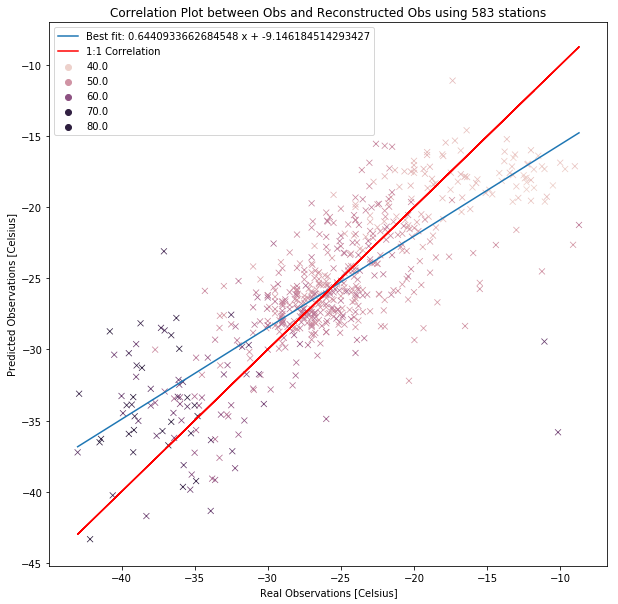

In [834]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print(regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('r2', r2)
print('rmse', rmse)

fig = plt.figure(figsize=(10, 10))
sns.lineplot(observations.T[:, 0], 
             y_predicted[:, 0],
             label='Best fit: {} x + {}'.format(regression_model.coef_[0][0], 
                                             regression_model.intercept_[0])
)
sns.scatterplot(observations[0, :],
            reconstructed_observations[0, :],
            marker='x', 
            color='blue',
            hue=np.array(latlist)[match_ens_obs_idx])
plt.title('Correlation Plot between Obs and Reconstructed Obs using {} stations'.format(observations.shape[1]))
plt.plot(observations[0, :], observations[0, :], color='r', label='1:1 Correlation')
plt.legend()
plt.xlabel('Real Observations [Celsius]')
plt.ylabel('Predicted Observations [Celsius]')
plt.savefig('first_predictions_using_obs')

## Using randomly sampled pseudo observations

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (27, 180) 
Matched Obs shape:  (180,)
Model score: 0.6690516757450014
0.6375940515868443
r2 0.628702158282655
rmse 0.6384988390772748


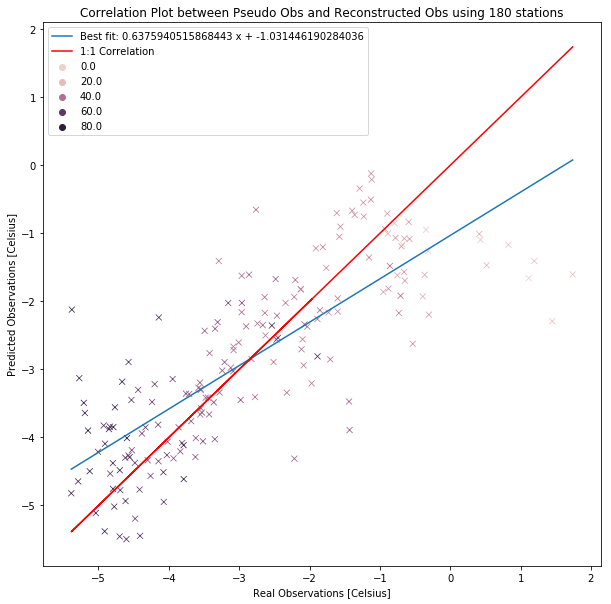

In [843]:
# generate pseudo observations from models to 
# compare the reconstruction to real observations with
pseudo_ens_obs, pseudo_idx = generate_pseudo_obs(ens[:, idx], 0.02)

match_obs_ens = pseudo_ens_obs*area_relevent_grid_cells[:, pseudo_idx]
match_model_ens = ens_eof[:, pseudo_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)
model = regress_eof(match_model_ens.T, match_obs_ens[0, :])
predictions = predict_dv(model, ens_eof.T)

observations = .10*match_obs_ens/area_relevent_grid_cells[:, pseudo_idx] 
reconstructed_observations = .10*predictions[pseudo_idx]/area_relevent_grid_cells[:, pseudo_idx]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print(regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('r2', r2)
print('rmse', rmse)

fig = plt.figure(figsize=(10, 10))
sns.lineplot(observations.T[:, 0], 
             y_predicted[:, 0],
             label='Best fit: {} x + {}'.format(regression_model.coef_[0][0], 
                                             regression_model.intercept_[0])
)
sns.scatterplot(observations[0, :],
            reconstructed_observations[0, :],
            marker='x', 
            color='blue',
            hue=np.array(latlist)[pseudo_idx])
plt.title('Correlation Plot between Obs and Reconstructed Obs using {} stations'.format(observations.shape[1]))
plt.plot(observations[0, :], observations[0, :], color='r', label='1:1 Correlation')
plt.legend()
plt.xlabel('Real Observations [Celsius]')
plt.ylabel('Predicted Observations [Celsius]')
plt.savefig('first_predictions_using_obs')

In [852]:
from mapper import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
#ax = plt.axes(projection=rp())
#ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

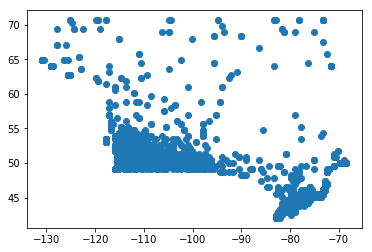

In [876]:
lat_ens, lon_ens = zip(*lat_lon_ens)
lat_ens, lon_ens = np.array(lat_ens)[df['nearest_grid'].values], np.array(lon_ens)[df['nearest_grid'].values]
plt.scatter(lon_ens, lat_ens)

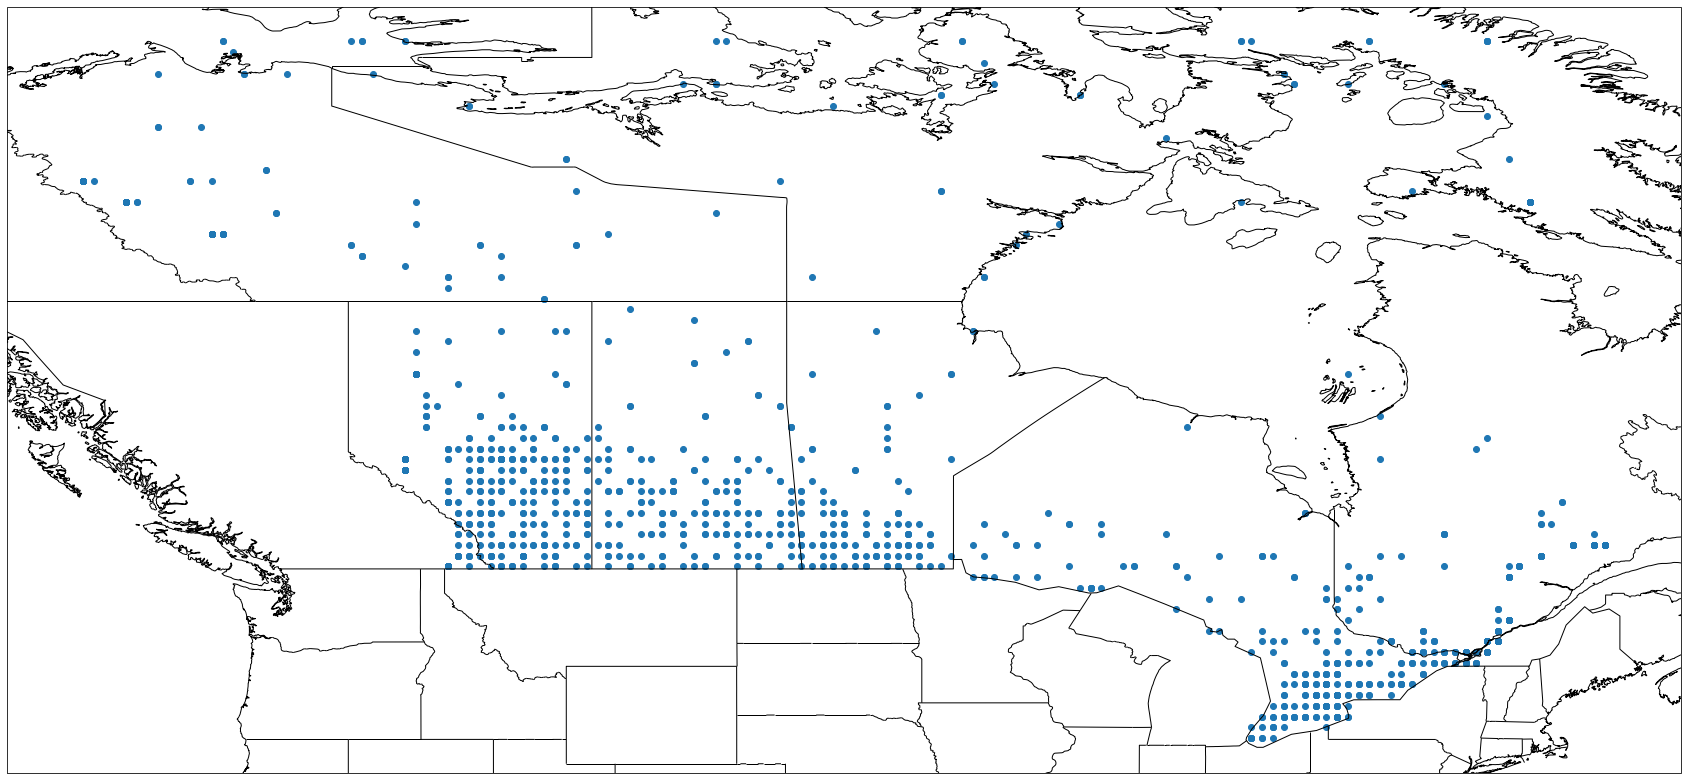

In [877]:
fig = plt.figure(figsize = (30, 45))

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)
plt.scatter(lon_ens, lat_ens)
plt.show()

In [878]:
df['nearest_grid'].values

array([5964, 5964, 5964, ..., 5436, 5721, 5436])

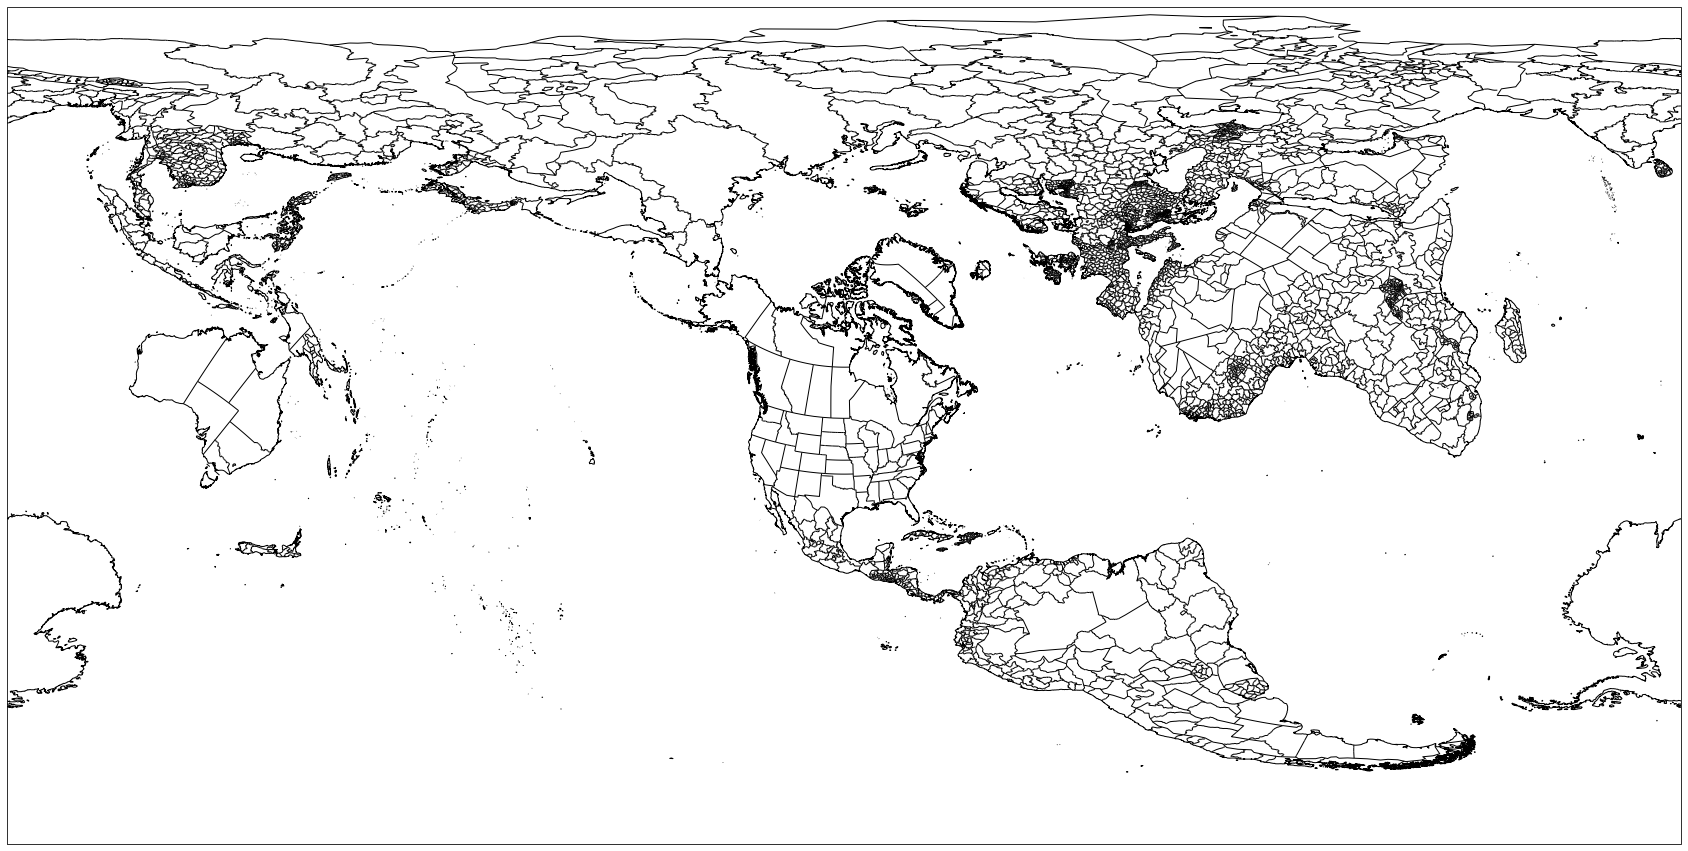

'plt.imshow(mask[0, ...], alpha=0.8, extent=[\n                                np.amin(dv_lon), \n                                np.amax(dv_lon),\n                                np.amax(dv_lat),\n                                np.amin(dv_lat)])'

In [852]:
"""fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=rp())
ax.coastlines(resolution='10m')

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

plt.imshow(mask_master[0, ...], extent=[
                                np.amin(dv_lon), 
                                np.amax(dv_lon),
                                np.amax(dv_lat),
                                np.amin(dv_lat)])
plt.gca().invert_yaxis()
plt.show()

"""
"""plt.imshow(mask[0, ...], alpha=0.8, extent=[
                                np.amin(dv_lon), 
                                np.amax(dv_lon),
                                np.amax(dv_lat),
                                np.amin(dv_lat)])"""
#ens[idx_arr[x, y]]
#ens_matched_cells = np.isin(mask_corr_dict['idx'], idx_arr[x, y])
#np.where(ens_matched_cells == True)[0].shape

#mask_corr_dict['idx'], np.sort(idx_arr[y, x])
#idx_list
#obs = df['quantile']*area_flat[ens_matched_cells][:, 0]